# **Semantic Segmentation Exercise**

Application: Change detection

Dataset:
Two images acquired at two different dates
Region of Cerrado Biome

Sensor: Landsat 8

Bands: 7 (each image)

Spatial Resolution: 30m x 30m

Image size: 1700 x 1440 px

![dataset](https://drive.google.com/uc?id=1vq8jZ4Y7v2uA2HamsEXeyVY-auKucC2c)

In [1]:
# from google.colab import drive
# # mount your Google Drive
# drive.mount('/content/drive', force_remount=True)
root_path = '/media/thimabru/ssd/Deep_Learning_aula/Homework3_ELE2765/FCN_Exercise_Data/' 

In [2]:
# Import libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Activation, Dense, Conv2D, MaxPool2D, Dropout, concatenate, UpSampling2D, Flatten
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import tensorflow.keras.backend as K

def load_tiff_image(image):
  print (image)
  gdal_header = gdal.Open(image)
  img = gdal_header.ReadAsArray()
  return img

def FCN(input_shape, n_classes):
  input_img = Input(input_shape)
  f1 = 16
  conv1 = Conv2D(f1 , (3 , 3) , activation='relu' , padding='same', name = 'conv1')(input_img) 
  pool1 = MaxPool2D((2 , 2))(conv1)

  conv2 = Conv2D(f1*2 , (3 , 3) , activation='relu' , padding='same', name = 'conv2')(pool1)
  pool2 = MaxPool2D((2 , 2))(conv2)

  conv3 = Conv2D(f1*4 , (3 , 3) , activation='relu' , padding='same', name = 'conv3')(pool2)
  pool3 = MaxPool2D((2 , 2))(conv3)

  conv4 = Conv2D(f1*8 , (3 , 3) , activation='relu' , padding='same', name = 'conv4')(pool3)

  upsample1 = Conv2D(f1*4, (3 , 3), activation = 'relu', padding = 'same', name = 'upsampling1')(UpSampling2D(size = (2,2))(conv4))

  upsample2 = Conv2D(f1*2, (3 , 3), activation = 'relu', padding = 'same', name = 'upsampling2')(UpSampling2D(size = (2,2))(upsample1))

  upsample3 = Conv2D(f1, (3 , 3), activation = 'relu', padding = 'same', name = 'upsampling3')(UpSampling2D(size = (2,2))(upsample2))
  
  output = Conv2D(n_classes,(1,1), activation = 'softmax')(upsample3)
  return Model(input_img , output) 

def weighted_categorical_crossentropy(weights):
  """
  A weighted version of keras.objectives.categorical_crossentropy
  
  Variables:
      weights: numpy array of shape (C,) where C is the number of classes
  
  Usage:
      weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
      loss = weighted_categorical_crossentropy(weights)
      model.compile(loss=loss,optimizer='adam')
  """
  weights = K.variable(weights)
  def loss(y_true, y_pred):
    # scale predictions so that the class probas of each sample sum to 1
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    # clip to prevent NaN's and Inf's
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    loss = y_true * K.log(y_pred) + (1-y_true) * K.log(1-y_pred)
    loss = loss * weights 
    loss = - K.mean(loss, -1)
    return loss
  return loss

def Train_model(net, patches_train, patches_tr_lb_h, batch_size, epochs, filepath, name):
  print('Start training.. ')
  for epoch in range(epochs):

    loss_tr = np.zeros((1 , 2))
    #Computing the number of batchs
    n_batchs_tr = patches_train.shape[0]//batch_size
    
    #Random shuffle the data
    patches_train , patches_tr_lb_h = shuffle(patches_train , patches_tr_lb_h , random_state = 0)
        
    # Training the network per batch
    for  batch in range(n_batchs_tr):
                
      x_train_b = patches_train[batch * batch_size : (batch + 1) * batch_size , : , : , :]
      y_train_h_b = patches_tr_lb_h[batch * batch_size : (batch + 1) * batch_size , :, :, :]
      
      loss_tr = loss_tr + net.train_on_batch(x_train_b , y_train_h_b)
    
    # Training loss
    loss_tr = loss_tr/n_batchs_tr
    
    print("%d [training loss: %f , Train acc.: %.2f%%]" %(epoch , loss_tr[0 , 0], 100*loss_tr[0 , 1]))
  # saving model    
    net.save(filepath+name+'.h5')

def Test(model, patch_test):
  result = model.predict(patch_test)
  predicted_class = np.argmax(result, axis=-1)
  return predicted_class

def compute_metrics(true_labels, predicted_labels):
  accuracy = 100*accuracy_score(true_labels, predicted_labels)
  f1score = 100*f1_score(true_labels, predicted_labels, average=None)
  recall = 100*recall_score(true_labels, predicted_labels, average=None)
  precision = 100*precision_score(true_labels, predicted_labels, average=None)
  return accuracy, f1score, recall, precision

# **Load data**

In [3]:
patches_tr = np.load(root_path+'tr_patches.npy')
patches_tr_ref = np.load(root_path+'tr_ref.npy')
print(patches_tr.shape)
print(patches_tr_ref.shape)

(324, 128, 128, 14)
(324, 128, 128)


In [4]:
# One hot enconding
number_class = 2
patches_tr_ref_h = tf.keras.utils.to_categorical(patches_tr_ref, number_class)
print(patches_tr_ref_h.shape)
patches_tr , patches_tr_ref_h = shuffle(patches_tr , patches_tr_ref_h , random_state = 0)

(324, 128, 128, 2)


In [5]:
# Set weights
weights = [1.04, 24.14]
#weights = weights/np.sum(weights)
print(weights)

[1.04, 24.14]


# **Train model**

In [9]:
# Parameters
batch_size = 32
epochs = 10
channels = 14
patch_size = 128
number_class = 2
filepath = root_path
name = 'model'

In [10]:
# Train the model
adam = Adam(lr = 0.0001 , beta_1=0.9)
net = FCN((patch_size, patch_size, channels), number_class)
net.summary()
loss = weighted_categorical_crossentropy(weights)
net.compile(loss = loss,optimizer=adam , metrics=['accuracy'])
Train_model(net, patches_tr, patches_tr_ref_h, batch_size, epochs, filepath, name)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 14)]    0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 16)      2032      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0     

# **Test model**

In [6]:
patches_ts = np.load(root_path+'ts_patches.npy')
patches_ts_ref = np.load(root_path+'ts_ref.npy')
print(patches_ts_ref.shape)
print(patches_ts_ref[14][:][:])

# Test model
model = load_model('FCN_Exercise_Data/model.h5', compile=False)
patches_pred = Test(model, patches_ts)
print(patches_pred.shape)

(48, 128, 128)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(48, 128, 128)


# **Metrics**

In [7]:
true_labels = np.reshape(patches_ts_ref, (patches_ts_ref.shape[0]* patches_ts_ref.shape[1]*patches_ts_ref.shape[2]))
predicted_labels = np.reshape(patches_pred, (patches_pred.shape[0]* patches_pred.shape[1]*patches_pred.shape[2]))

metrics = compute_metrics(true_labels, predicted_labels)
cm = confusion_matrix(true_labels, predicted_labels)

print('Confusion  matrix \n', cm)
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

Confusion  matrix 
 [[737597   7160]
 [ 14340  27335]]
Accuracy:  97.26613362630209
F1score:  [98.56350062 71.77366417]
Recall:  [99.03861259 65.59088182]
Precision:  [98.09292534 79.2433686 ]


# **Visualization**

(-0.5, 127.5, 127.5, -0.5)

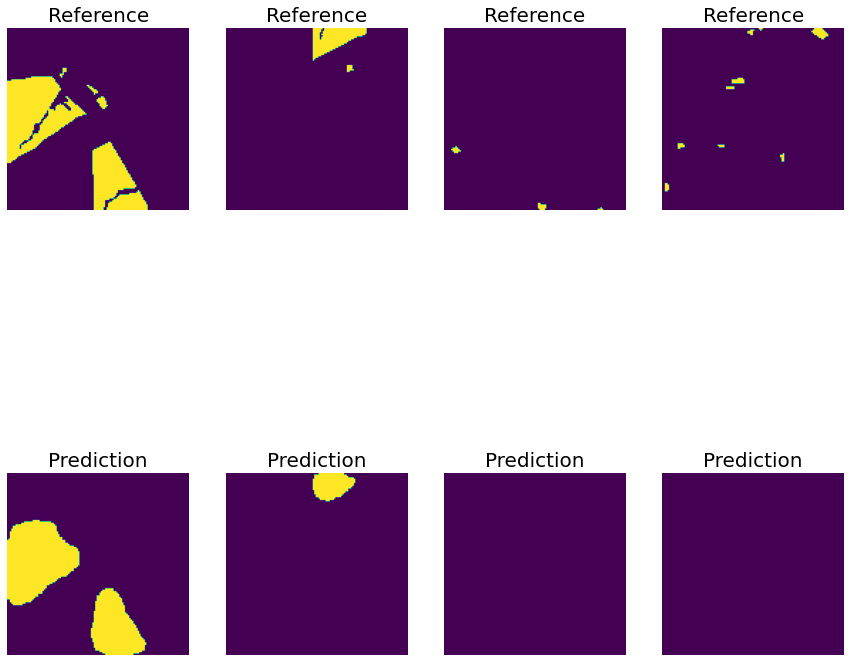

In [9]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7,ax8)) = plt.subplots(2, 4, figsize=(15, 15))
# Reference
ax1.imshow(patches_ts_ref[0,:,:])
ax1.set_title('Reference', fontsize=20)
ax1.axis('off')
ax2.imshow(patches_ts_ref[1,:,:])
ax2.set_title('Reference', fontsize=20)
ax2.axis('off')
ax3.imshow(patches_ts_ref[2,:,:])
ax3.set_title('Reference', fontsize=20)
ax3.axis('off')
ax4.imshow(patches_ts_ref[3,:,:])
ax4.set_title('Reference', fontsize=20)
ax4.axis('off')

# Predictions
ax5.imshow(patches_pred[0,:,:])
ax5.set_title('Prediction', fontsize=20)
ax5.axis('off')
ax6.imshow(patches_pred[1,:,:])
ax6.set_title('Prediction', fontsize=20)
ax6.axis('off')
ax7.imshow(patches_pred[2,:,:])
ax7.set_title('Prediction', fontsize=20)
ax7.axis('off')
ax8.imshow(patches_pred[3,:,:])
ax8.set_title('Prediction', fontsize=20)
ax8.axis('off')